In [199]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Suprimir todos os warnings
warnings.filterwarnings("ignore")

In [200]:
pd.set_option('display.max_colwidth', None) #para ver as descrições dos eventos


In [201]:
url_events = "https://eonet.gsfc.nasa.gov/api/v3/events"
url_categorias = "https://eonet.gsfc.nasa.gov/api/v3/categories"
url_layers = "https://eonet.gsfc.nasa.gov/api/v3/layers"
url_source = "https://eonet.gsfc.nasa.gov/api/v3/sources"


In [202]:
response_events = requests.get(url_events)


In [203]:
response_categorias = requests.get(url_categorias)

In [204]:
response_layers = requests.get(url_layers)

In [205]:
response_source = requests.get(url_source)


In [206]:
#captura a informação dos json
data_events = response_events.json()
data_categorias = response_categorias.json()
data_layers = response_layers.json()
data_source = response_source.json()


events = data_events['events']
categorias = data_categorias['categories']
layers = data_layers['categories']
source = data_source['sources']



df_events = pd.json_normalize(events)
df_categorias = pd.json_normalize(categorias)
df_layers = pd.json_normalize(data_layers['categories'], 'layers')
df_source = pd.json_normalize(source)
    
    

In [207]:
#título das categorias dos eventos
categorias = df_categorias[['title','description']]

#alinha titulo e conteudo do df para a esquerda
categorias= categorias.style.set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'left')]},    
     {'selector': 'td', 'props': [('text-align', 'left')]}]    
)

categorias


,title,description
0,Drought,"Long lasting absence of precipitation affecting agriculture and livestock, and the overall availability of food and water."
1,Dust and Haze,"Related to dust storms, air pollution and other non-volcanic aerosols. Volcano-related plumes shall be included with the originating eruption event."
2,Earthquakes,Related to all manner of shaking and displacement. Certain aftermath of earthquakes may also be found under landslides and floods.
3,Floods,"Related to aspects of actual flooding--e.g., inundation, water extending beyond river and lake extents."
4,Landslides,"Related to landslides and variations thereof: mudslides, avalanche."
5,Manmade,Events that have been human-induced and are extreme in their extent.
6,Sea and Lake Ice,"Related to all ice that resides on oceans and lakes, including sea and lake ice (permanent and seasonal) and icebergs."
7,Severe Storms,"Related to the atmospheric aspect of storms (hurricanes, cyclones, tornadoes, etc.). Results of storms may be included under floods, landslides, etc."
8,Snow,"Related to snow events, particularly extreme/anomalous snowfall in either timing or extent/depth."
9,Temperature Extremes,"Related to anomalous land temperatures, either heat or cold."


In [208]:
#titulos de todos os eventos existentes no dataframe
titulos = df_events['categories'].apply(lambda x: [d['id'] for d in x])
titulos.head()
# titulos.explode('titulos')


0    [severeStorms]
1    [severeStorms]
2    [severeStorms]
3       [wildfires]
4       [wildfires]
Name: categories, dtype: object

In [209]:
#todos os tipos de eventos armazenados 
titulos_exploded = titulos.explode('titulos')


titulos_unicos = titulos_exploded.unique()
print(titulos_unicos)

['severeStorms' 'wildfires' 'volcanoes' 'seaLakeIce']


In [210]:
#descrição dos eventos únicos 
selecao = df_categorias.query('title == "Wildfires" | title =="Volcanoes" | title == "Severe Storms" | title == "Sea and Lake Ice"')
for i in range(4):
    print(selecao['title'].iloc[i], end=": ")
    print(selecao['description'].iloc[i])

Sea and Lake Ice: Related to all ice that resides on oceans and lakes, including sea and lake ice (permanent and seasonal) and icebergs.
Severe Storms: Related to the atmospheric aspect of storms (hurricanes, cyclones, tornadoes, etc.). Results of storms may be included under floods, landslides, etc.
Volcanoes: Related to both the physical effects of an eruption (rock, ash, lava) and the atmospheric (ash and gas plumes).
Wildfires: Wildfires includes all nature of fire, including forest and plains fires, as well as urban and industrial fire events. Fires may be naturally caused or manmade.


In [211]:
contagem = titulos_exploded.value_counts()
contagem.head()

categories
wildfires       3600
seaLakeIce        45
volcanoes         33
severeStorms       5
Name: count, dtype: int64

<Axes: xlabel='categories', ylabel='quantidade'>

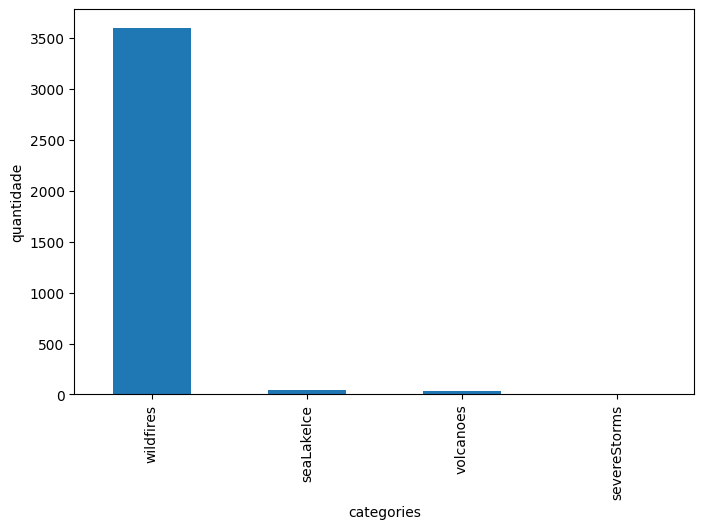

In [212]:

contagem.plot(kind = 'bar', xlabel= 'categories', ylabel='quantidade',  figsize= (8,5))

In [213]:

df_events['categoria_evento'] = titulos.apply(lambda x: x[0] ) 

# df_events.head(1)


In [214]:


magnitude = df_events['geometry'].apply(lambda x: [d['magnitudeValue'] for d in x])

magnitude.head()

df_events['magnitude_evento'] = magnitude
# df_events.head(1)

Média das magnitudes dos wildfires, evento menos ocorrido: Severe Storms

In [215]:
df_events_storms = df_events.query('categoria_evento == "severeStorms"')
df_events_storms.head(1)
df_events_storms['media_magnitude'] = df_events_storms['magnitude_evento'].apply(lambda x: np.mean(x))
# df_events_storms

df_magnitude_grafico = df_events_storms[['title', 'media_magnitude']]
df_magnitude_grafico.head()

# df_magnitude_grafico.set_index('title', inplace=True)
# df_magnitude_grafico.plot(kind='bar', ylabel = 'kts', xlabel = 'title')

C:\Users\danie\AppData\Local\Temp\ipykernel_18804\2160549154.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_events_storms['media_magnitude'] = df_events_storms['magnitude_evento'].apply(lambda x: np.mean(x))


,title,media_magnitude
0,Tropical Cyclone Dana,56.250000
1,Hurricane Kristy,85.200000
2,Tropical Storm Trami,45.200000
5,Tropical Storm Oscar,54.615385
6,Tropical Storm Nadine,33.333333


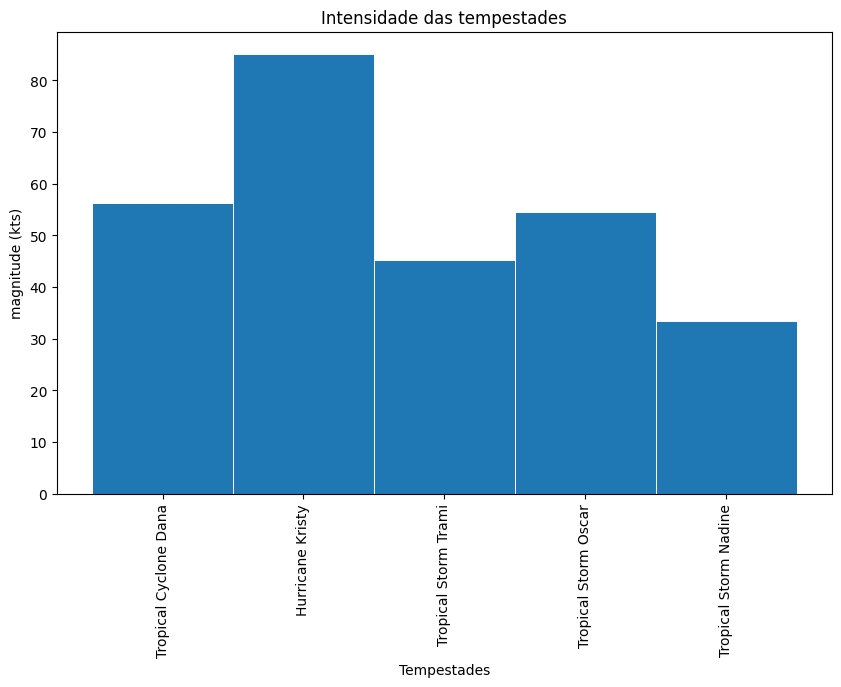

In [216]:
x = df_magnitude_grafico['title']
y = df_magnitude_grafico['media_magnitude']

plt.figure(figsize=(10, 6))  # Define o tamanho do gráfico
plt.bar(x, y, width=1, edgecolor="white", linewidth=0.7)

plt.xticks(rotation=90)

plt.xlabel('Tempestades')
plt.ylabel('magnitude (kts)')
plt.title('Intensidade das tempestades')

plt.show()




In [217]:
data_events = df_events_storms['geometry'].apply(lambda x: [d['date'] for d in x])
data_events_inicio = data_events.apply(lambda x: x[0])
data_events_inicio

0    2024-10-23T06:00:00Z
1    2024-10-21T18:00:00Z
2    2024-10-21T18:00:00Z
5    2024-10-19T15:00:00Z
6    2024-10-19T09:00:00Z
Name: geometry, dtype: object

In [218]:
df_events_wildfire = df_events.query('categoria_evento == "wildfires"')
# df_events_wildfire.shape
df_wildfire_tempo = df_events_wildfire[['title','magnitude_evento']]

df_wildfire_tempo['magnitude_evento'] = df_wildfire_tempo['magnitude_evento'].apply(lambda x: x[0])
df_wildfire_tempo['data'] = df_events_wildfire['geometry'].apply(lambda x: [d['date'] for d in x] )

df_wildfire_tempo['data'] = df_wildfire_tempo['data'].apply(lambda x: x[0])
df_wildfire_tempo['data'] = pd.to_datetime(df_wildfire_tempo['data'], errors='coerce')
df_wildfire_tempo['data'] = df_wildfire_tempo['data'].dt.month

# df_wildfire_tempo.head()

# df_wildfire_tempo.query("data !=10 ").shape



C:\Users\danie\AppData\Local\Temp\ipykernel_18804\3850866681.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wildfire_tempo['magnitude_evento'] = df_wildfire_tempo['magnitude_evento'].apply(lambda x: x[0])
C:\Users\danie\AppData\Local\Temp\ipykernel_18804\3850866681.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wildfire_tempo['data'] = df_events_wildfire['geometry'].apply(lambda x: [d['date'] for d in x] )
C:\Users\danie\AppData\Local\Temp\ipykernel_18804\3850866681.py:8: SettingWithCopyWarn

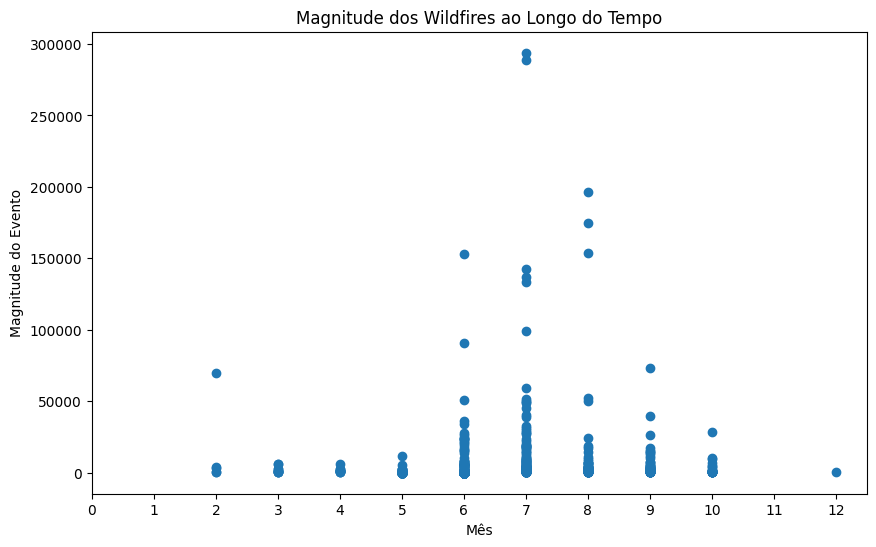

In [219]:
x = df_wildfire_tempo['data']  # coluna de datas, representando os meses
y = df_wildfire_tempo['magnitude_evento']  # coluna de magnitude do evento

# Criar o gráfico de dispersão
plt.figure(figsize=(10, 6))  # Define o tamanho do gráfico
plt.scatter(x, y)

# Personalizar o gráfico
plt.xlabel("Mês")
plt.ylabel("Magnitude do Evento")
plt.title("Magnitude dos Wildfires ao Longo do Tempo")

plt.xticks(np.arange(0, 13, step=1))
plt.show()


In [220]:
quantidade_wildfires_mes = df_wildfire_tempo["data"].value_counts().sort_values()
quantidade_wildfires_mes = pd.DataFrame(quantidade_wildfires_mes)

grafico_quantidae_wildfires = pd.DataFrame()
grafico_quantidae_wildfires['quantidade'] = quantidade_wildfires_mes
grafico_quantidae_wildfires.sort_values(by="data", inplace= True)

# quantidade_wildfires_mes.columns
# df_wildfire_tempo
quantidade_wildfires_mes


,count
data,
12,1
2,5
3,11
4,12
5,86
10,189
6,558
9,682
7,930


In [221]:
# grafico_quantidae_wildfires.plot(kind="bar",xlabel="mês", ylabel='quantidade de incêncios')
df_grafico_wildfires_1 = df_wildfire_tempo["data"].value_counts().sort_values()





<BarContainer object of 10 artists>

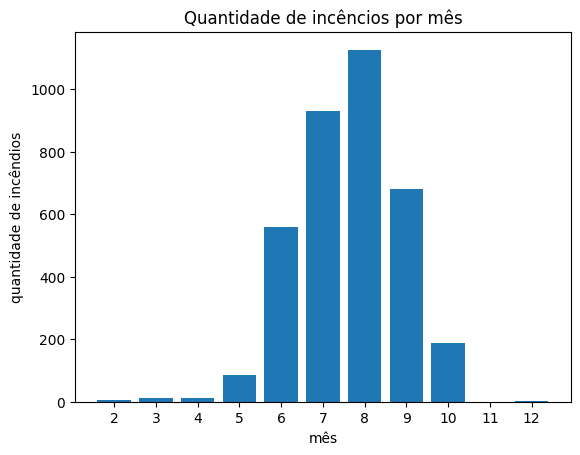

In [222]:
x = df_grafico_wildfires_1.index
y = quantidade_wildfires_mes['count']

plt.xlabel("mês")
plt.ylabel("quantidade de incêndios")
plt.title("Quantidade de incêncios por mês")

plt.xticks(np.arange(0, 13, step=1))
plt.bar(x,y)




In [223]:
# max = df_events_wildfire.nlargest(10, 'magnitude_evento')
# max
df_wildfires

NameError: name 'df_wildfires' is not defined